In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

In [3]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)


# 1.特徴量作る

trainとtestまとめて特徴量作る 

In [4]:
os.chdir("..\data")

<input>:1: DeprecationWarning:

invalid escape sequence \d

<input>:1: DeprecationWarning:

invalid escape sequence \d

<input>:1: DeprecationWarning:

invalid escape sequence \d

<ipython-input-4-42502f29d081>:1: DeprecationWarning:

invalid escape sequence \d



In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
compose = pd.concat((train,test),axis=0)
compose = compose.reset_index().copy()
print(train.shape)
print(test.shape)
#print(compose.shape)
#print(compose)

(2101, 6)
(365, 5)


日付関連

In [6]:
compose.loc[:,"timestamp"] = pd.to_datetime(compose.loc[:,"datetime"])
compose.loc[:,"year"] = compose["timestamp"].apply(lambda x:x.year)
compose.loc[:,"month"] = compose["timestamp"].apply(lambda x:x.month)
compose.loc[:,"day"] = compose["timestamp"].apply(lambda x:x.day)
compose.loc[:,"weekday"] = compose["timestamp"].apply(lambda x:x.dayofweek)
compose.loc[:,"elapsed_days"] = compose.loc[:,"timestamp"].apply(lambda x:(x-compose.loc[0,"timestamp"]).days)
print(compose.shape)

(2466, 13)


https://www.jpm.jp/marketdata/　の成約数（datetimeの去年のデータを使うようにする）

In [7]:
period = ["2009b","2010u","2010b","2011u","2011b","2012u","2012b",
          "2013u","2013b","2014u","2014b","2015u","2015b","2016u","2016b"]
tintai_di = [-14.0,-21.6,-10.8,-4.2,10.4,16.6,31.1,4.1,16.8,9.9,24.5,15.8,13.8,14.9,26.3]
baibai_di = [-21.9,-15.8,1.8,6.4,4.7,9.0,17.1,10.9,26.5,21.9,31.4,17.8,18.7,18.6,23.5]

In [8]:
tintai_di_b = []
for i in range(0,len(tintai_di),2):
    tintai_di_b.append(tintai_di[i])
tintai_di_u = []
for i in range(1,len(tintai_di),2):
    tintai_di_u.append(tintai_di[i])
baibai_di_b = []
for i in range(0,len(baibai_di),2):
    baibai_di_b.append(baibai_di[i])
baibai_di_u = []
for i in range(1,len(baibai_di),2):
    baibai_di_u.append(baibai_di[i])
tintai_di_b_cum = pd.Series(tintai_di_b).cumsum()
tintai_di_u_cum = pd.Series(tintai_di_u).cumsum()
baibai_di_u_cum = pd.Series(baibai_di_u).cumsum()
baibai_di_b_cum = pd.Series(baibai_di_b).cumsum()
p_dict ={}
for  (p,t,b) in zip(period,tintai_di,baibai_di):
    p_dict[p] =(t,b)

In [9]:
def period_mapping(datetime):
    if ((pd.to_datetime("2008-10-01")<datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2008b")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009u")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2009b")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010u")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2010b")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011u")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2011b")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012u")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2012b")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013u")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2013b")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014u")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2014b")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015u")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2015b")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016u")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2016b")

In [10]:
compose.loc[:,"period"] = (compose.loc[:,"timestamp"]).apply(lambda x:period_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u


In [11]:
di_tuple = compose.loc[:,"period"].map(p_dict)
compose.loc[:,"tintai_bi"] = di_tuple.map(lambda x:x[0])
compose.loc[:,"baibai_di"] = di_tuple.map(lambda x:x[1])
print(compose.shape)
#compose.head()

(2466, 16)


関東労働力

In [12]:
period1 = ["2010Q1","2010Q2","2010Q3","2010Q4"
          ,"2011Q1","2011Q2","2011Q3","2011Q4" ,"2012Q1","2012Q2","2012Q3","2012Q4"
          ,"2013Q1","2013Q2","2013Q3","2013Q4","2014Q1","2014Q2","2014Q3","2014Q4"
          ,"2015Q1","2015Q2","2015Q3","2015Q4","2016Q1","2016Q2","2016Q3","2016Q4"
          ,"2017Q1","2017Q2","2017Q3","2017Q4","2018Q1"]
ibaragi = [1535,1561,1560,1554,1533,1560,1553,1546,
           1522,1547,1540,1533,1506,1532,1527,1522,
           1503,1536,1534,1528,1505,1533,1530,1523,
           1504,1532,1527,1520,1500,1527,1518,1513,1491]

totigi =  [1060,1089,1079,1069,1058,1083,1072,1064,
           1054,1079,1068,1055,1045,1070,1060,1047,
           1041,1071,1062,1050,1040,1066,1057,1044,
           1037,1064,1055,1042,1034,1061,1049,1037,1029]

gunma =   [1020,1054,1053,1039,1024,1053,1048,1033,
           1017,1043,1045,1028,1010,1036,1039,1022,
           1007,1040,1043,1025,1006,1034,1034,1018,
           1004,1031,1035,1018,1002,1032,1032,1015,997]

saitama =[3778,3860,3904,3875,3820,3872,3889,3870,
          3793,3843,3834,3817,3743,3779,3795,3781,
          3710,3766,3789,3784,3729,3796,3814,3816,
          3776,3842,3849,3864,3803,3848,3874,3893,3832]

tiba = [3265,3327,3320,3284,3270,3324,3319,3291,
       3274,3309,3298,3274,3268,3316,3308,3280,
       3271,3312,3308,3286,3275,3315,3306,3287,
        3282,3324,3312,3292,3294,3339,3342,3326,3306]

tokyo =[7227,7370,7350,7312,7330,7419,7322,7410,
        7460,7529,7323,7385,7402,7506,7407,7345,
        7431,7581,7433,7512,7534,7732,7560,7646,
        7582,7774,7718,7716,7634,7765,7803,7869,7795]

kanagawa =[4804,4792,4778,4739,4769,4798,4780,4763,
          4717,4789,4775,4769,4770,4777,4689,4759,
          4870,4808,4743,4773,4773,4775,4900,4825,
          4784,4816,4870,4797,4908,4973,4944,4897,4946]

total =[22699,23053,23044,22872,22804,23109,22983,22977,
        22837,23139,22883,22861,22744,23016,22825,22756,
        22833,23114,22912,22958,22862,23251,23201,23159,
        22969,23383,23366,23249,23175,23545,23562,23550,23396]

In [13]:
kanto_dict ={}
for  (p,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total) in zip(period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total):
    kanto_dict[p] =(ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total)

In [14]:
def period1_mapping(datetime):
    if ((pd.to_datetime("2009-1-1")<=datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2009Q1")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-6-30"))):
        return("2009Q2")
    elif ((pd.to_datetime("2009-6-30")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009Q3")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2009-12-31"))):
        return("2009Q4")
    elif ((pd.to_datetime("2010-1-1")<=datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2010Q1")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-6-30"))):
        return("2010Q2")
    elif ((pd.to_datetime("2010-6-30")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010Q3")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2010-12-31"))):
        return("2010Q4")
    elif ((pd.to_datetime("2011-1-1")<=datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2011Q1")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-6-30"))):
        return("2011Q2")
    elif ((pd.to_datetime("2011-6-30")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011Q3")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2011-12-31"))):
        return("2011Q4")
    elif ((pd.to_datetime("2012-1-1")<=datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2012Q1")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-6-30"))):
        return("2012Q2")
    elif ((pd.to_datetime("2012-6-30")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012Q3")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2012-12-31"))):
        return("2012Q4")
    elif ((pd.to_datetime("2013-1-1")<=datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2013Q1")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-6-30"))):
        return("2013Q2")
    elif ((pd.to_datetime("2013-6-30")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013Q3")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2013-12-31"))):
        return("2013Q4")
    elif ((pd.to_datetime("2014-1-1")<=datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2014Q1")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-6-30"))):
        return("2014Q2")
    elif ((pd.to_datetime("2014-6-30")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014Q3")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2014-12-31"))):
        return("2014Q4")
    elif ((pd.to_datetime("2015-1-1")<=datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2015Q1")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-6-30"))):
        return("2015Q2")
    elif ((pd.to_datetime("2015-6-30")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015Q3")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2015-12-31"))):
        return("2015Q4")
    elif ((pd.to_datetime("2016-1-1")<=datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2016Q1")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-6-30"))):
        return("2016Q2")
    elif ((pd.to_datetime("2016-6-30")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016Q3")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2016-12-31"))):
        return("2016Q4")
    elif ((pd.to_datetime("2017-1-1")<=datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2017Q1")


In [15]:
compose.loc[:,"periodQ"] = (compose.loc[:,"timestamp"]).apply(lambda x:period1_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,periodQ
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3


In [16]:
kanto_ro = compose.loc[:,"periodQ"].map(kanto_dict)
compose.loc[:,"ibaragi"] = kanto_ro.map(lambda x:x[0])
compose.loc[:,"totigi"] = kanto_ro.map(lambda x:x[1])
compose.loc[:,"gunma"] = kanto_ro.map(lambda x:x[2])
compose.loc[:,"saitama"] = kanto_ro.map(lambda x:x[3])
compose.loc[:,"tiba"] = kanto_ro.map(lambda x:x[4])
compose.loc[:,"tokyo"] = kanto_ro.map(lambda x:x[5])
compose.loc[:,"kanagawa"] = kanto_ro.map(lambda x:x[6])
compose.loc[:,"total"] = kanto_ro.map(lambda x:x[7])

print(compose.shape)


(2466, 25)


失業率

In [17]:
unemp = pd.read_csv("data2.csv")
print(unemp.shape)
compose=pd.concat([compose,unemp],axis=1)
compose.head()

(2466, 7)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,periodQ,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91


In [18]:
imigrant=pd.read_csv("imigrant2.csv")
print(imigrant.shape)
compose=pd.concat([compose,imigrant],axis=1)
compose.head()

(2466, 13)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,periodQ,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91,2009/7/1,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91,2009/7/2,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91,2009/7/3,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986


時系列のデータ 7日前まで

In [19]:
compose_1 = compose.copy()
compose_1.loc[:,"timestamp"] = compose_1.loc[:,"timestamp"] + DateOffset(days=1)
compose_2 = compose.copy()
compose_2.loc[:,"timestamp"] = compose_2.loc[:,"timestamp"] + DateOffset(days=2)
compose_3 = compose.copy()
compose_3.loc[:,"timestamp"] = compose_3.loc[:,"timestamp"] + DateOffset(days=3)
compose_4 = compose.copy()
compose_4.loc[:,"timestamp"] = compose_4.loc[:,"timestamp"] + DateOffset(days=4)
compose_5 = compose.copy()
compose_5.loc[:,"timestamp"] = compose_5.loc[:,"timestamp"] + DateOffset(days=5)
compose_6 = compose.copy()
compose_6.loc[:,"timestamp"] = compose_6.loc[:,"timestamp"] + DateOffset(days=6)
compose_7 = compose.copy()
compose_7.loc[:,"timestamp"] = compose_7.loc[:,"timestamp"] + DateOffset(days=7)


In [20]:
temp =  pd.merge(compose,compose_1, on ="timestamp", suffixes=("","1"))
temp =  pd.merge(temp,compose_2, on ="timestamp", suffixes=("","2"))
temp =  pd.merge(temp,compose_3, on ="timestamp", suffixes=("","3"))
temp =  pd.merge(temp,compose_4, on ="timestamp", suffixes=("","4"))
temp =  pd.merge(temp,compose_5, on ="timestamp", suffixes=("","5"))
temp =  pd.merge(temp,compose_6, on ="timestamp", suffixes=("","6"))
temp =  pd.merge(temp,compose_7, on ="timestamp", suffixes=("","7"))

In [21]:
compose = temp.copy()
print(compose.shape)
compose.head()

(2459, 353)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,periodQ,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o,index1,client1,close1,datetime1,price_am1,price_pm1,y1,year1,month1,day1,weekday1,elapsed_days1,period1,tintai_bi1,baibai_di1,periodQ1,ibaragi1,totigi1,gunma1,saitama1,tiba1,tokyo1,kanagawa1,total1,date1,next1,new1,total_unemp1,men1,women1,head1,date1,Saitama_i1,Saitama_O1,Tiba_i1,Tiba_O1,Tokyo_i1,Tokyo_O1,Kanagawa_i1,Kanagawa_O1,Osaka_i1,Osaka_O1,Total_i1,Total_o1,index2,client2,close2,datetime2,price_am2,price_pm2,y2,year2,month2,day2,weekday2,elapsed_days2,period2,tintai_bi2,baibai_di2,periodQ2,ibaragi2,totigi2,gunma2,saitama2,tiba2,tokyo2,kanagawa2,total2,date2,next2,new2,total_unemp2,men2,women2,head2,date2,Saitama_i2,Saitama_O2,Tiba_i2,Tiba_O2,Tokyo_i2,Tokyo_O2,Kanagawa_i2,Kanagawa_O2,Osaka_i2,Osaka_O2,Total_i2,Total_o2,index3,client3,close3,datetime3,price_am3,price_pm3,y3,year3,month3,day3,weekday3,elapsed_days3,period3,tintai_bi3,baibai_di3,periodQ3,ibaragi3,totigi3,gunma3,saitama3,tiba3,tokyo3,kanagawa3,total3,date3,next3,new3,total_unemp3,men3,women3,head3,date3,Saitama_i3,Saitama_O3,Tiba_i3,Tiba_O3,Tokyo_i3,Tokyo_O3,Kanagawa_i3,Kanagawa_O3,Osaka_i3,Osaka_O3,Total_i3,Total_o3,index4,client4,close4,datetime4,price_am4,price_pm4,y4,year4,month4,day4,weekday4,elapsed_days4,period4,tintai_bi4,baibai_di4,periodQ4,ibaragi4,totigi4,gunma4,saitama4,tiba4,tokyo4,kanagawa4,total4,date4,next4,new4,total_unemp4,men4,women4,head4,date4,Saitama_i4,Saitama_O4,Tiba_i4,Tiba_O4,Tokyo_i4,Tokyo_O4,Kanagawa_i4,Kanagawa_O4,Osaka_i4,Osaka_O4,Total_i4,Total_o4,index5,client5,close5,datetime5,price_am5,price_pm5,y5,year5,month5,day5,weekday5,elapsed_days5,period5,tintai_bi5,baibai_di5,periodQ5,ibaragi5,totigi5,gunma5,saitama5,tiba5,tokyo5,kanagawa5,total5,date5,next5,new5,total_unemp5,men5,women5,head5,date5,Saitama_i5,Saitama_O5,Tiba_i5,Tiba_O5,Tokyo_i5,Tokyo_O5,Kanagawa_i5,Kanagawa_O5,Osaka_i5,Osaka_O5,Total_i5,Total_o5,index6,client6,close6,datetime6,price_am6,price_pm6,y6,year6,month6,day6,weekday6,elapsed_days6,period6,tintai_bi6,baibai_di6,periodQ6,ibaragi6,totigi6,gunma6,saitama6,tiba6,tokyo6,kanagawa6,total6,date6,next6,new6,total_unemp6,men6,women6,head6,date6,Saitama_i6,Saitama_O6,Tiba_i6,Tiba_O6,Tokyo_i6,Tokyo_O6,Kanagawa_i6,Kanagawa_O6,Osaka_i6,Osaka_O6,Total_i6,Total_o6,index7,client7,close7,datetime7,price_am7,price_pm7,y7,year7,month7,day7,weekday7,elapsed_days7,period7,tintai_bi7,baibai_di7,periodQ7,ibaragi7,totigi7,gunma7,saitama7,tiba7,tokyo7,kanagawa7,total7,date7,next7,new7,total_unemp7,men7,women7,head7,date7,Saitama_i7,Saitama_O7,Tiba_i7,Tiba_O7,Tokyo_i7,Tokyo_O7,Kanagawa_i7,Kanagawa_O7,Osaka_i7,Osaka_O7,Total_i7,Total_o7
0,7,0,0,2010-07-08,-1,-1,10.0,2010-07-08,2010,7,8,3,7,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/8,270,85,355,225,138,91,2009/7/8,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,6,0,0,2010-07-07,-1,-1,4.0,2010,7,7,2,6,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/7,270,85,355,225,138,91,2009/7/7,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,5,0,0,2010-07-06,-1,-1,14.0,2010,7,6,1,5,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/6,270,85,355,225,138,91,2009/7/6,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,4,0,0,2010-07-05,-1,-1,14.0,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986,3,0,0,2010-07-04,-1,-1,20.0,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,409

In [22]:
compose.to_csv("compose.csv",index=None)

# 2.モデリング

2014-3-31までのデータをtrain、2015-4-1～2016-3-31をテストとする(本当のテストデータは2016-4-1～2017-3-31）

In [23]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2015-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2015-4-1")) & (compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()
print(train.shape)
print(test.shape)

(1728, 353)
(366, 353)


In [24]:
#ここでモデリングに使う特徴量を選択する
feature_name=['client', 'close', 'price_am',"price_pm",'year', 'month', 'day', 'weekday',
              "y1","y2","y3","y4","y5","y6","y7",
              'month1','day1', 'weekday1',
            'month2', 'day2', 'weekday2',
              'month3', 'day3', 'weekday3',
               'month4', 'day4', 'weekday4',
               'month5', 'day5', 'weekday5',
              'month6', 'day6', 'weekday6',
              'month7', 'day7', 'weekday7',
              "new","total","men","head",
              "ibaragi","totigi","gunma","saitama","tiba","tokyo","kanagawa"
             ]

In [25]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(1728, 47)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,new,total,men,head,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778


In [26]:
#gridsearch 時間かかるのでパラメータ調整したいときのみ実行

xgb_pars = []

MCWlist = [10, 20, 30,40,50]
ETAlist =  [0.05,0.1,0.2,0.3]
CSlist = [0.3,0.5,0.7]
MDlist =  [6,7,8,9,10]
SSlist = [0.5,0.7,0.9]
LAMBDAlist = [0.5,0.6,0.7]

for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:

                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',

                                         'silent': 1, 'objective': 'reg:linear'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)
print(patterns)

2700


In [28]:
#CV
scores =[]
for i in range(len(xgb_pars)):
    res = xgb.cv(xgb_pars[i], dtrain, num_boost_round=1000,early_stopping_rounds=50,
                 nfold=5,metrics={'rmse'}, seed = 0,verbose_eval = None)
    scores.append(res.loc[:,"test-rmse-mean"].min())
    print(i/patterns)

    
print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

0.0


KeyboardInterrupt: 

In [27]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6, 'subsample': 0.9, 
            'lambda': 0.6, 'nthread': -1, 
            'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [28]:
models = []
for i in range(100):
    Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=i)
    dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
    dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
    watchlist = [(dtrain,"train"),(dvalid,"valid")]
    model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
    models.append(model)

[0]	train-rmse:33.3805	valid-rmse:33.7668
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.8919	valid-rmse:21.1929
[20]	train-rmse:13.5165	valid-rmse:13.8614
[30]	train-rmse:9.25408	valid-rmse:9.82802
[40]	train-rmse:6.8644	valid-rmse:7.77539
[50]	train-rmse:5.59447	valid-rmse:6.84308
[60]	train-rmse:4.92503	valid-rmse:6.42001
[70]	train-rmse:4.53904	valid-rmse:6.24029
[80]	train-rmse:4.27307	valid-rmse:6.17818
[90]	train-rmse:4.09952	valid-rmse:6.12468
[100]	train-rmse:3.98101	valid-rmse:6.10992
[110]	train-rmse:3.87455	valid-rmse:6.09271
[120]	train-rmse:3.76819	valid-rmse:6.065
[130]	train-rmse:3.67928	valid-rmse:6.04637
[140]	train-rmse:3.60956	valid-rmse:6.0271
[150]	train-rmse:3.54212	valid-rmse:6.03546
[160]	train-rmse:3.46253	valid-rmse:6.02071
[170]	train-rmse:3.3984	valid-rmse:6.00495
[180]	train-rmse:3.33194	valid-rmse:5.99474
[190]	train-rmse:3.27622	valid-rmse

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.0822	valid-rmse:20.2416
[20]	train-rmse:13.674	valid-rmse:13.185
[30]	train-rmse:9.35453	valid-rmse:9.30239
[40]	train-rmse:6.9296	valid-rmse:7.39511
[50]	train-rmse:5.63484	valid-rmse:6.58215
[60]	train-rmse:4.94048	valid-rmse:6.24066
[70]	train-rmse:4.5318	valid-rmse:6.12704
[80]	train-rmse:4.27867	valid-rmse:6.09333
[90]	train-rmse:4.08896	valid-rmse:6.07235
[100]	train-rmse:3.98093	valid-rmse:6.0715
[110]	train-rmse:3.88213	valid-rmse:6.0532
[120]	train-rmse:3.80435	valid-rmse:6.03919
[130]	train-rmse:3.72399	valid-rmse:6.05124
[140]	train-rmse:3.65449	valid-rmse:6.04296
[150]	train-rmse:3.57775	valid-rmse:6.04677
[160]	train-rmse:3.51334	valid-rmse:6.04404
[170]	train-rmse:3.43914	valid-rmse:6.04248
[180]	train-rmse:3.38734	valid-rmse:6.05008
[190]	train-rmse:3.3158	valid-rmse:6.05399
Stopping. Best iteration:
[144]	train-rmse:3.61675	valid-rmse:6.037

[0]	train-rmse:33.8132	valid-rmse:32.0365
Multiple ev

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.3037	valid-rmse:19.3413
[20]	train-rmse:13.767	valid-rmse:12.7106
[30]	train-rmse:9.38221	valid-rmse:9.06798
[40]	train-rmse:6.94055	valid-rmse:7.3434
[50]	train-rmse:5.63967	valid-rmse:6.58839
[60]	train-rmse:4.94854	valid-rmse:6.2728
[70]	train-rmse:4.55081	valid-rmse:6.12833
[80]	train-rmse:4.30047	valid-rmse:6.04981
[90]	train-rmse:4.1318	valid-rmse:5.99115
[100]	train-rmse:3.99622	valid-rmse:5.98929
[110]	train-rmse:3.88584	valid-rmse:5.9869
[120]	train-rmse:3.79298	valid-rmse:5.98579
[130]	train-rmse:3.71455	valid-rmse:5.96888
[140]	train-rmse:3.64261	valid-rmse:5.96481
[150]	train-rmse:3.58434	valid-rmse:5.9581
[160]	train-rmse:3.51782	valid-rmse:5.95128
[170]	train-rmse:3.44069	valid-rmse:5.96342
[180]	train-rmse:3.38138	valid-rmse:5.95979
[190]	train-rmse:3.32811	valid-rmse:5.9559
[200]	train-rmse:3.26657	valid-rmse:5.95249
Stopping. Best iteration:
[155]	train-rmse:3.55051	valid-rmse:5.94689

[0]	tra

[150]	train-rmse:3.60311	valid-rmse:5.93701
[160]	train-rmse:3.52101	valid-rmse:5.93644
[170]	train-rmse:3.45395	valid-rmse:5.93962
[180]	train-rmse:3.38706	valid-rmse:5.94427
[190]	train-rmse:3.33967	valid-rmse:5.9441
[200]	train-rmse:3.29915	valid-rmse:5.94318
[210]	train-rmse:3.21489	valid-rmse:5.95033
Stopping. Best iteration:
[163]	train-rmse:3.50339	valid-rmse:5.92885

[0]	train-rmse:33.4452	valid-rmse:33.5287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.9487	valid-rmse:21.0992
[20]	train-rmse:13.5753	valid-rmse:14.0135
[30]	train-rmse:9.29867	valid-rmse:10.1296
[40]	train-rmse:6.88998	valid-rmse:8.16317
[50]	train-rmse:5.63625	valid-rmse:7.30771
[60]	train-rmse:4.96789	valid-rmse:6.92712
[70]	train-rmse:4.56562	valid-rmse:6.75678
[80]	train-rmse:4.31866	valid-rmse:6.65688
[90]	train-rmse:4.13151	valid-rmse:6.60431
[100]	train-rmse:4.0163	valid-rmse:6.55265
[110]

[0]	train-rmse:33.8754	valid-rmse:31.7606
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.1853	valid-rmse:20.0687
[20]	train-rmse:13.6641	valid-rmse:13.337
[30]	train-rmse:9.30057	valid-rmse:9.72261
[40]	train-rmse:6.86084	valid-rmse:8.01562
[50]	train-rmse:5.53259	valid-rmse:7.27551
[60]	train-rmse:4.82259	valid-rmse:7.00159
[70]	train-rmse:4.43688	valid-rmse:6.9202
[80]	train-rmse:4.19056	valid-rmse:6.86887
[90]	train-rmse:4.02439	valid-rmse:6.84764
[100]	train-rmse:3.90684	valid-rmse:6.85045
[110]	train-rmse:3.80935	valid-rmse:6.84992
[120]	train-rmse:3.7234	valid-rmse:6.84224
[130]	train-rmse:3.63417	valid-rmse:6.84015
[140]	train-rmse:3.57167	valid-rmse:6.82991
[150]	train-rmse:3.49096	valid-rmse:6.82974
[160]	train-rmse:3.41726	valid-rmse:6.81976
[170]	train-rmse:3.35381	valid-rmse:6.8324
[180]	train-rmse:3.29254	valid-rmse:6.82794
[190]	train-rmse:3.21769	valid-rms

[260]	train-rmse:2.89392	valid-rmse:5.73289
[270]	train-rmse:2.8404	valid-rmse:5.73817
[280]	train-rmse:2.78774	valid-rmse:5.73436
[290]	train-rmse:2.74248	valid-rmse:5.73821
[300]	train-rmse:2.69012	valid-rmse:5.73024
Stopping. Best iteration:
[253]	train-rmse:2.93486	valid-rmse:5.72295

[0]	train-rmse:33.5607	valid-rmse:33.1191
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.0019	valid-rmse:21.0671
[20]	train-rmse:13.5659	valid-rmse:14.059
[30]	train-rmse:9.28238	valid-rmse:10.2332
[40]	train-rmse:6.86008	valid-rmse:8.2492
[50]	train-rmse:5.56867	valid-rmse:7.27203
[60]	train-rmse:4.90256	valid-rmse:6.83803
[70]	train-rmse:4.51519	valid-rmse:6.6359
[80]	train-rmse:4.27199	valid-rmse:6.53993
[90]	train-rmse:4.08848	valid-rmse:6.48901
[100]	train-rmse:3.97445	valid-rmse:6.4554
[110]	train-rmse:3.87598	valid-rmse:6.41569
[120]	train-rmse:3.79955	valid-rmse:6.40407
[130]	tr

[140]	train-rmse:3.65643	valid-rmse:6.25686
[150]	train-rmse:3.5993	valid-rmse:6.25059
[160]	train-rmse:3.52735	valid-rmse:6.23008
[170]	train-rmse:3.43879	valid-rmse:6.23061
[180]	train-rmse:3.39084	valid-rmse:6.21949
[190]	train-rmse:3.30815	valid-rmse:6.21503
[200]	train-rmse:3.26137	valid-rmse:6.21403
[210]	train-rmse:3.19149	valid-rmse:6.20939
[220]	train-rmse:3.12592	valid-rmse:6.21359
[230]	train-rmse:3.06192	valid-rmse:6.21181
[240]	train-rmse:2.98571	valid-rmse:6.20693
[250]	train-rmse:2.94385	valid-rmse:6.1918
[260]	train-rmse:2.86893	valid-rmse:6.19686
[270]	train-rmse:2.83285	valid-rmse:6.203
[280]	train-rmse:2.78942	valid-rmse:6.20953
[290]	train-rmse:2.74529	valid-rmse:6.21266
[300]	train-rmse:2.69479	valid-rmse:6.21643
Stopping. Best iteration:
[252]	train-rmse:2.93203	valid-rmse:6.18774

[0]	train-rmse:32.9963	valid-rmse:35.3112
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds

[160]	train-rmse:3.55441	valid-rmse:6.14675
[170]	train-rmse:3.48082	valid-rmse:6.14986
[180]	train-rmse:3.40576	valid-rmse:6.13161
[190]	train-rmse:3.3348	valid-rmse:6.15577
[200]	train-rmse:3.27716	valid-rmse:6.15552
[210]	train-rmse:3.2067	valid-rmse:6.1621
[220]	train-rmse:3.13369	valid-rmse:6.14783
[230]	train-rmse:3.06669	valid-rmse:6.13741
Stopping. Best iteration:
[180]	train-rmse:3.40576	valid-rmse:6.13161

[0]	train-rmse:33.4036	valid-rmse:33.7992
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.8732	valid-rmse:21.5314
[20]	train-rmse:13.4849	valid-rmse:14.4946
[30]	train-rmse:9.21928	valid-rmse:10.6312
[40]	train-rmse:6.80761	valid-rmse:8.59384
[50]	train-rmse:5.51234	valid-rmse:7.63521
[60]	train-rmse:4.83872	valid-rmse:7.2042
[70]	train-rmse:4.45739	valid-rmse:7.01686
[80]	train-rmse:4.21943	valid-rmse:6.91404
[90]	train-rmse:4.03633	valid-rmse:6.87394
[100]	t

[50]	train-rmse:5.5832	valid-rmse:7.42185
[60]	train-rmse:4.91482	valid-rmse:7.02107
[70]	train-rmse:4.54541	valid-rmse:6.82495
[80]	train-rmse:4.31221	valid-rmse:6.73191
[90]	train-rmse:4.15151	valid-rmse:6.68688
[100]	train-rmse:4.00435	valid-rmse:6.6684
[110]	train-rmse:3.89937	valid-rmse:6.63537
[120]	train-rmse:3.78626	valid-rmse:6.62456
[130]	train-rmse:3.69477	valid-rmse:6.61788
[140]	train-rmse:3.63497	valid-rmse:6.61366
[150]	train-rmse:3.57712	valid-rmse:6.62154
[160]	train-rmse:3.48858	valid-rmse:6.64202
[170]	train-rmse:3.40348	valid-rmse:6.65971
[180]	train-rmse:3.34047	valid-rmse:6.66962
Stopping. Best iteration:
[139]	train-rmse:3.64248	valid-rmse:6.60963

[0]	train-rmse:33.5976	valid-rmse:32.9296
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.0484	valid-rmse:20.842
[20]	train-rmse:13.633	valid-rmse:13.8916
[30]	train-rmse:9.3007	valid-rmse:10.0741
[40]	tr

[90]	train-rmse:4.15408	valid-rmse:6.11404
[100]	train-rmse:4.03683	valid-rmse:6.11201
[110]	train-rmse:3.93783	valid-rmse:6.11832
[120]	train-rmse:3.85324	valid-rmse:6.11415
[130]	train-rmse:3.7594	valid-rmse:6.12425
[140]	train-rmse:3.69123	valid-rmse:6.14576
[150]	train-rmse:3.62556	valid-rmse:6.15257
Stopping. Best iteration:
[103]	train-rmse:4.0001	valid-rmse:6.10442

[0]	train-rmse:33.6838	valid-rmse:32.5772
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.0865	valid-rmse:20.297
[20]	train-rmse:13.6274	valid-rmse:13.2585
[30]	train-rmse:9.31586	valid-rmse:9.47771
[40]	train-rmse:6.85972	valid-rmse:7.67861
[50]	train-rmse:5.54237	valid-rmse:6.94681
[60]	train-rmse:4.85425	valid-rmse:6.69088
[70]	train-rmse:4.47167	valid-rmse:6.58687
[80]	train-rmse:4.21254	valid-rmse:6.54937
[90]	train-rmse:4.04264	valid-rmse:6.51902
[100]	train-rmse:3.90459	valid-rmse:6.5202
[110]	tr

[150]	train-rmse:3.56333	valid-rmse:6.2943
[160]	train-rmse:3.47955	valid-rmse:6.29195
[170]	train-rmse:3.40331	valid-rmse:6.29973
[180]	train-rmse:3.35633	valid-rmse:6.29811
[190]	train-rmse:3.29941	valid-rmse:6.30684
[200]	train-rmse:3.23013	valid-rmse:6.30517
[210]	train-rmse:3.17221	valid-rmse:6.3056
Stopping. Best iteration:
[161]	train-rmse:3.47548	valid-rmse:6.28946

[0]	train-rmse:33.8035	valid-rmse:32.0629
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.1522	valid-rmse:20.1598
[20]	train-rmse:13.6919	valid-rmse:13.2621
[30]	train-rmse:9.34285	valid-rmse:9.52019
[40]	train-rmse:6.89817	valid-rmse:7.68141
[50]	train-rmse:5.60327	valid-rmse:6.87391
[60]	train-rmse:4.91518	valid-rmse:6.55182
[70]	train-rmse:4.5283	valid-rmse:6.4461
[80]	train-rmse:4.28018	valid-rmse:6.42382
[90]	train-rmse:4.08812	valid-rmse:6.38029
[100]	train-rmse:3.97388	valid-rmse:6.37856
[110]	t

[20]	train-rmse:13.6153	valid-rmse:13.3884
[30]	train-rmse:9.30209	valid-rmse:9.65253
[40]	train-rmse:6.87913	valid-rmse:7.89132
[50]	train-rmse:5.57623	valid-rmse:7.12519
[60]	train-rmse:4.88769	valid-rmse:6.83768
[70]	train-rmse:4.4975	valid-rmse:6.71898
[80]	train-rmse:4.25659	valid-rmse:6.67244
[90]	train-rmse:4.08616	valid-rmse:6.6212
[100]	train-rmse:3.9524	valid-rmse:6.5985
[110]	train-rmse:3.8481	valid-rmse:6.55796
[120]	train-rmse:3.779	valid-rmse:6.54818
[130]	train-rmse:3.70978	valid-rmse:6.52978
[140]	train-rmse:3.64436	valid-rmse:6.5126
[150]	train-rmse:3.57676	valid-rmse:6.50499
[160]	train-rmse:3.50265	valid-rmse:6.49451
[170]	train-rmse:3.43687	valid-rmse:6.48297
[180]	train-rmse:3.36289	valid-rmse:6.4714
[190]	train-rmse:3.30293	valid-rmse:6.46307
[200]	train-rmse:3.23322	valid-rmse:6.45512
[210]	train-rmse:3.17343	valid-rmse:6.45829
[220]	train-rmse:3.10797	valid-rmse:6.4534
[230]	train-rmse:3.05742	valid-rmse:6.44117
[240]	train-rmse:3.00527	valid-rmse:6.44028
[250]	

[70]	train-rmse:4.51647	valid-rmse:6.81756
[80]	train-rmse:4.28559	valid-rmse:6.7327
[90]	train-rmse:4.0915	valid-rmse:6.66356
[100]	train-rmse:3.95065	valid-rmse:6.64801
[110]	train-rmse:3.84285	valid-rmse:6.62584
[120]	train-rmse:3.74194	valid-rmse:6.62556
[130]	train-rmse:3.6777	valid-rmse:6.6326
[140]	train-rmse:3.60318	valid-rmse:6.61476
[150]	train-rmse:3.53633	valid-rmse:6.6204
[160]	train-rmse:3.46518	valid-rmse:6.62305
[170]	train-rmse:3.38074	valid-rmse:6.61388
[180]	train-rmse:3.33358	valid-rmse:6.60719
[190]	train-rmse:3.26528	valid-rmse:6.60088
[200]	train-rmse:3.2003	valid-rmse:6.59025
[210]	train-rmse:3.11421	valid-rmse:6.59251
[220]	train-rmse:3.06119	valid-rmse:6.5964
[230]	train-rmse:2.99417	valid-rmse:6.59675
[240]	train-rmse:2.93597	valid-rmse:6.59763
[250]	train-rmse:2.87951	valid-rmse:6.5926
Stopping. Best iteration:
[205]	train-rmse:3.15315	valid-rmse:6.58043

[0]	train-rmse:33.3452	valid-rmse:33.8665
Multiple eval metrics have been passed: 'valid-rmse' will be u

[30]	train-rmse:9.36378	valid-rmse:9.78957
[40]	train-rmse:6.95199	valid-rmse:7.781
[50]	train-rmse:5.65738	valid-rmse:6.81084
[60]	train-rmse:4.99201	valid-rmse:6.38697
[70]	train-rmse:4.61799	valid-rmse:6.18233
[80]	train-rmse:4.3688	valid-rmse:6.09039
[90]	train-rmse:4.18471	valid-rmse:6.05129
[100]	train-rmse:4.03401	valid-rmse:6.03707
[110]	train-rmse:3.95021	valid-rmse:6.01327
[120]	train-rmse:3.86821	valid-rmse:5.99664
[130]	train-rmse:3.78875	valid-rmse:5.98608
[140]	train-rmse:3.69851	valid-rmse:5.97373
[150]	train-rmse:3.61997	valid-rmse:5.98459
[160]	train-rmse:3.52171	valid-rmse:5.98686
[170]	train-rmse:3.43588	valid-rmse:5.99545
[180]	train-rmse:3.38157	valid-rmse:5.99017
[190]	train-rmse:3.32264	valid-rmse:5.99892
Stopping. Best iteration:
[140]	train-rmse:3.69851	valid-rmse:5.97373

[0]	train-rmse:33.7396	valid-rmse:32.3621
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:21.3178	valid-rmse:19.1837
[20]	train-rmse:13.7622	valid-rmse:12.4774
[30]	train-rmse:9.3979	valid-rmse:8.88688
[40]	train-rmse:6.94763	valid-rmse:7.23242
[50]	train-rmse:5.63155	valid-rmse:6.52734
[60]	train-rmse:4.92557	valid-rmse:6.27873
[70]	train-rmse:4.52486	valid-rmse:6.22685
[80]	train-rmse:4.28378	valid-rmse:6.2169
[90]	train-rmse:4.10522	valid-rmse:6.20734
[100]	train-rmse:3.9726	valid-rmse:6.22338
[110]	train-rmse:3.86512	valid-rmse:6.21603
[120]	train-rmse:3.78678	valid-rmse:6.21477
[130]	train-rmse:3.71133	valid-rmse:6.21222
Stopping. Best iteration:
[89]	train-rmse:4.12673	valid-rmse:6.20285

[0]	train-rmse:33.2706	valid-rmse:34.2634
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.8124	valid-rmse:21.5185
[20]	train-rmse:13.4441	valid-rmse:14.1301
[30]	train-rmse:9.18408	valid-rmse:10.0

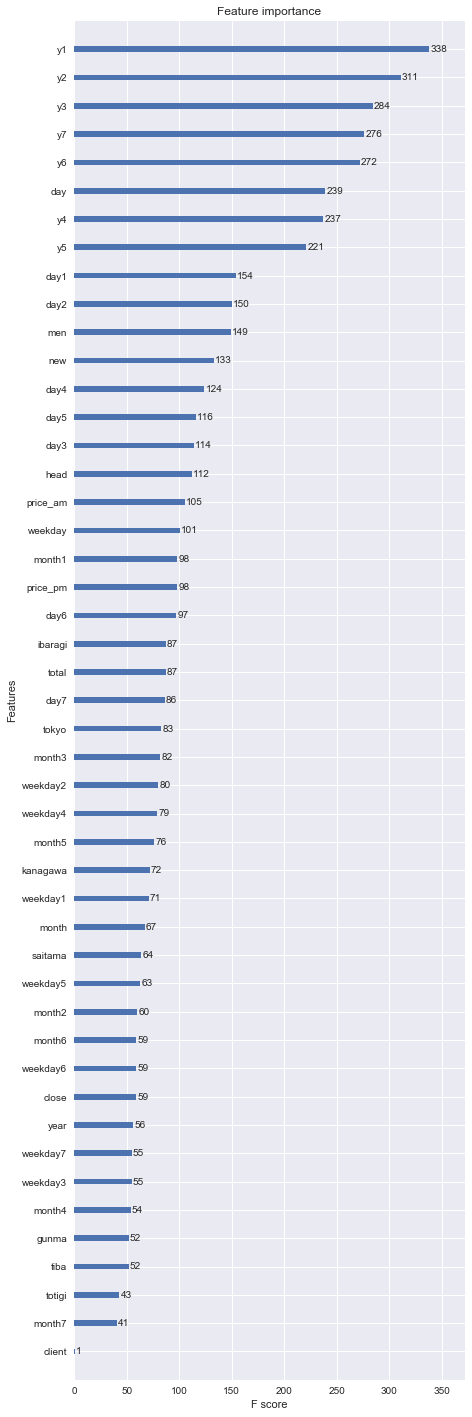

In [29]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

# 3.Predict

In [29]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predicts = []
for i in range(100):
    train_predict = models[i].predict(dfeature)
    train_predicts.append(train_predict)

In [30]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(366, 47)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,new,total,men,head,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa
0,1,0,3,3,2015,4,1,2,75.0,87.0,96.0,88.0,95.0,85.0,78.0,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,3,25,2,68,23251,145,54,1533,1066,1034,3796,3315,7732,4775
1,1,0,2,2,2015,4,2,3,61.0,75.0,87.0,96.0,88.0,95.0,85.0,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,68,23251,145,54,1533,1066,1034,3796,3315,7732,4775
2,1,0,2,1,2015,4,3,4,60.0,61.0,75.0,87.0,96.0,88.0,95.0,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,68,23251,145,54,1533,1066,1034,3796,3315,7732,4775
3,1,0,4,3,2015,4,4,5,75.0,60.0,61.0,75.0,87.0,96.0,88.0,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,68,23251,145,54,1533,1066,1034,3796,3315,7732,4775
4,1,0,2,2,2015,4,5,6,86.0,75.0,60.0,61.0,75.0,87.0,96.0,4,4,5,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,68,23251,145,54,1533,1066,1034,3796,3315,7732,4775


In [31]:
test_predicts =[]
for i in range(100):
    dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
    test_predict = models[i].predict(dtest)
    test_predicts.append(test_predict)
    

In [32]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()
te_diviation = test["y"]-test_predict
te_mae = np.absolute(te_diviation).mean()
print("trainデータの予想のMAE =",tr_mae)
print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 2.88043673976359
testデータの予想のMAE = 6.950033322709506


In [33]:
for i in range(100):
    tr_diviation = train["y"]-train_predicts[i]
    tr_mae = np.absolute(tr_diviation).mean()
    te_diviation = test["y"]-test_predicts[i]
    te_mae = np.absolute(te_diviation).mean()
    print("trainデータの予想のMAE =",tr_mae)
    print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 2.614770766761568
testデータの予想のMAE = 7.142939878291771
trainデータの予想のMAE = 2.2979215088438383
testデータの予想のMAE = 7.108587257197646
trainデータの予想のMAE = 2.6645527628112444
testデータの予想のMAE = 7.057739892292544
trainデータの予想のMAE = 3.1100473749727287
testデータの予想のMAE = 7.039521053189137
trainデータの予想のMAE = 3.1110837136015848
testデータの予想のMAE = 7.1768321033383975
trainデータの予想のMAE = 2.7990142310176185
testデータの予想のMAE = 7.066861644631526
trainデータの予想のMAE = 2.957256377398692
testデータの予想のMAE = 7.353515205487527
trainデータの予想のMAE = 2.7781205239740236
testデータの予想のMAE = 7.044073708721848
trainデータの予想のMAE = 2.5645246068360628
testデータの予想のMAE = 6.929289241957534
trainデータの予想のMAE = 2.9051224977916315
testデータの予想のMAE = 7.095452116486805
trainデータの予想のMAE = 2.505313851094494
testデータの予想のMAE = 7.124506025366444
trainデータの予想のMAE = 2.8437065830005817
testデータの予想のMAE = 6.948532509999197
trainデータの予想のMAE = 2.9158226243668683
testデータの予想のMAE = 7.121119075785569
trainデータの予想のMAE = 3.1680478119049913
testデータの予想のMAE = 7.0031577423

In [34]:

train_predict = sum(train_predicts)/100
test_predict = sum(test_predicts)/100

In [35]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()
te_diviation = test["y"]-test_predict
te_mae = np.absolute(te_diviation).mean()
print("trainデータの予想のMAE =",tr_mae)
print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 2.7967371359053583
testデータの予想のMAE = 6.921078592050271


In [36]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(1728, 2)


,predict,datetime
0,11.716425,2010-07-08
1,13.161807,2010-07-09
2,18.552654,2010-07-10
3,15.127097,2010-07-11
4,12.419273,2010-07-12


In [37]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(366, 2)


,predict,datetime
0,62.279308,2015-04-01
1,55.640171,2015-04-02
2,56.726810,2015-04-03
3,59.284595,2015-04-04
4,63.186386,2015-04-05


In [38]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2094, 2)


,predict,datetime
0,11.716425,2010-07-08
1,13.161807,2010-07-09
2,18.552654,2010-07-10
3,15.127097,2010-07-11
4,12.419273,2010-07-12


In [39]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

# 4.提出

提出は2015-3-31までをtrain,2016-4-1~2017-3-31までをtestとする

In [40]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()
print(train.shape)
print(test.shape)

(2094, 353)
(365, 353)


In [41]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(2094, 47)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,new,total,men,head,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,85,23044,225,91,1560,1079,1053,3904,3320,7350,4778


In [42]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6,
            'subsample': 0.9, 'lambda': 0.7, 'nthread': -1, 'booster': 'gbtree', 
            'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [43]:
models = []
for i in range(100):
    Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=i)
    dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
    dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
    watchlist = [(dtrain,"train"),(dvalid,"valid")]
    model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)
    models.append(model)



[0]	train-rmse:36.2882	valid-rmse:35.4915
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.7186	valid-rmse:22.2933
[20]	train-rmse:14.6577	valid-rmse:14.636
[30]	train-rmse:10.0469	valid-rmse:10.4468
[40]	train-rmse:7.51293	valid-rmse:8.35866
[50]	train-rmse:6.1396	valid-rmse:7.34385
[60]	train-rmse:5.42448	valid-rmse:6.92945
[70]	train-rmse:5.03315	valid-rmse:6.74424
[80]	train-rmse:4.76378	valid-rmse:6.66294
[90]	train-rmse:4.58136	valid-rmse:6.63272
[100]	train-rmse:4.43398	valid-rmse:6.61005
[110]	train-rmse:4.3366	valid-rmse:6.59655
[120]	train-rmse:4.22309	valid-rmse:6.59318
[130]	train-rmse:4.11544	valid-rmse:6.61211
[140]	train-rmse:4.04386	valid-rmse:6.61847
[150]	train-rmse:3.96191	valid-rmse:6.61519
[160]	train-rmse:3.88422	valid-rmse:6.61329
[170]	train-rmse:3.81288	valid-rmse:6.61423
Stopping. Best iteration:
[121]	train-rmse:4.20751	valid-rmse:6.59296

[0]	tr

[0]	train-rmse:35.8718	valid-rmse:37.177
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.4612	valid-rmse:23.6188
[20]	train-rmse:14.5189	valid-rmse:15.5811
[30]	train-rmse:9.97214	valid-rmse:11.0291
[40]	train-rmse:7.48245	valid-rmse:8.67074
[50]	train-rmse:6.15188	valid-rmse:7.48304
[60]	train-rmse:5.43018	valid-rmse:6.92024
[70]	train-rmse:5.0143	valid-rmse:6.67156
[80]	train-rmse:4.77212	valid-rmse:6.54585
[90]	train-rmse:4.58401	valid-rmse:6.4712
[100]	train-rmse:4.43811	valid-rmse:6.4164
[110]	train-rmse:4.32233	valid-rmse:6.38281
[120]	train-rmse:4.23488	valid-rmse:6.37681
[130]	train-rmse:4.13603	valid-rmse:6.37168
[140]	train-rmse:4.07285	valid-rmse:6.34579
[150]	train-rmse:3.97786	valid-rmse:6.33076
[160]	train-rmse:3.90947	valid-rmse:6.32716
[170]	train-rmse:3.81104	valid-rmse:6.32524
[180]	train-rmse:3.75256	valid-rmse:6.32245
[190]	train-rmse:3.6848	valid-rmse

[210]	train-rmse:3.55012	valid-rmse:6.38524
[220]	train-rmse:3.48347	valid-rmse:6.37998
[230]	train-rmse:3.39245	valid-rmse:6.38598
[240]	train-rmse:3.34019	valid-rmse:6.38951
[250]	train-rmse:3.27414	valid-rmse:6.39236
[260]	train-rmse:3.20935	valid-rmse:6.39454
[270]	train-rmse:3.15728	valid-rmse:6.38738
Stopping. Best iteration:
[222]	train-rmse:3.46773	valid-rmse:6.37895

[0]	train-rmse:36.1888	valid-rmse:35.9433
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.6578	valid-rmse:22.8583
[20]	train-rmse:14.601	valid-rmse:15.173
[30]	train-rmse:9.98238	valid-rmse:10.9371
[40]	train-rmse:7.4318	valid-rmse:8.75573
[50]	train-rmse:6.08212	valid-rmse:7.68756
[60]	train-rmse:5.35022	valid-rmse:7.19455
[70]	train-rmse:4.96186	valid-rmse:6.95935
[80]	train-rmse:4.70587	valid-rmse:6.86831
[90]	train-rmse:4.53691	valid-rmse:6.81047
[100]	train-rmse:4.38727	valid-rmse:6.77377
[110]	

[160]	train-rmse:3.97967	valid-rmse:6.31417
[170]	train-rmse:3.88955	valid-rmse:6.31819
[180]	train-rmse:3.807	valid-rmse:6.31405
Stopping. Best iteration:
[133]	train-rmse:4.16773	valid-rmse:6.29694

[0]	train-rmse:36.5034	valid-rmse:34.6014
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.8458	valid-rmse:21.5626
[20]	train-rmse:14.7338	valid-rmse:14.0212
[30]	train-rmse:10.0752	valid-rmse:9.96742
[40]	train-rmse:7.52037	valid-rmse:7.98418
[50]	train-rmse:6.14538	valid-rmse:7.09267
[60]	train-rmse:5.41674	valid-rmse:6.73324
[70]	train-rmse:5.02395	valid-rmse:6.59608
[80]	train-rmse:4.75982	valid-rmse:6.56061
[90]	train-rmse:4.58125	valid-rmse:6.51536
[100]	train-rmse:4.44144	valid-rmse:6.50864
[110]	train-rmse:4.33422	valid-rmse:6.49997
[120]	train-rmse:4.23089	valid-rmse:6.4943
[130]	train-rmse:4.10869	valid-rmse:6.48761
[140]	train-rmse:4.05079	valid-rmse:6.47811
[150]	

[70]	train-rmse:4.98041	valid-rmse:6.95593
[80]	train-rmse:4.70418	valid-rmse:6.85295
[90]	train-rmse:4.5202	valid-rmse:6.78509
[100]	train-rmse:4.3807	valid-rmse:6.74552
[110]	train-rmse:4.27604	valid-rmse:6.70255
[120]	train-rmse:4.16973	valid-rmse:6.66497
[130]	train-rmse:4.08763	valid-rmse:6.66599
[140]	train-rmse:4.03482	valid-rmse:6.66547
[150]	train-rmse:3.96345	valid-rmse:6.65602
[160]	train-rmse:3.91358	valid-rmse:6.64562
[170]	train-rmse:3.83411	valid-rmse:6.61407
[180]	train-rmse:3.76835	valid-rmse:6.60599
[190]	train-rmse:3.72175	valid-rmse:6.60103
[200]	train-rmse:3.67759	valid-rmse:6.59299
[210]	train-rmse:3.59976	valid-rmse:6.59665
[220]	train-rmse:3.55451	valid-rmse:6.59415
[230]	train-rmse:3.5104	valid-rmse:6.59563
[240]	train-rmse:3.43929	valid-rmse:6.5951
[250]	train-rmse:3.37128	valid-rmse:6.59824
[260]	train-rmse:3.31381	valid-rmse:6.59404
[270]	train-rmse:3.24289	valid-rmse:6.59976
[280]	train-rmse:3.18598	valid-rmse:6.60481
[290]	train-rmse:3.12063	valid-rmse:6.6

[20]	train-rmse:14.4034	valid-rmse:16.0793
[30]	train-rmse:9.8446	valid-rmse:11.5888
[40]	train-rmse:7.3409	valid-rmse:9.29219
[50]	train-rmse:6.00259	valid-rmse:8.13247
[60]	train-rmse:5.30617	valid-rmse:7.62009
[70]	train-rmse:4.91593	valid-rmse:7.37441
[80]	train-rmse:4.64384	valid-rmse:7.27377
[90]	train-rmse:4.46708	valid-rmse:7.21921
[100]	train-rmse:4.31785	valid-rmse:7.16418
[110]	train-rmse:4.19874	valid-rmse:7.14154
[120]	train-rmse:4.08634	valid-rmse:7.11364
[130]	train-rmse:3.98388	valid-rmse:7.0991
[140]	train-rmse:3.90001	valid-rmse:7.07751
[150]	train-rmse:3.8237	valid-rmse:7.08182
[160]	train-rmse:3.74416	valid-rmse:7.08734
[170]	train-rmse:3.65388	valid-rmse:7.09089
[180]	train-rmse:3.58011	valid-rmse:7.09353
Stopping. Best iteration:
[138]	train-rmse:3.9225	valid-rmse:7.07463

[0]	train-rmse:36.5185	valid-rmse:34.5271
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	tr

[0]	train-rmse:36.0696	valid-rmse:36.3769
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.5452	valid-rmse:23.0109
[20]	train-rmse:14.5278	valid-rmse:15.2044
[30]	train-rmse:9.91503	valid-rmse:10.9574
[40]	train-rmse:7.36795	valid-rmse:8.80542
[50]	train-rmse:5.98526	valid-rmse:7.77372
[60]	train-rmse:5.25555	valid-rmse:7.34893
[70]	train-rmse:4.85118	valid-rmse:7.15567
[80]	train-rmse:4.60313	valid-rmse:7.08096
[90]	train-rmse:4.42995	valid-rmse:7.04645
[100]	train-rmse:4.29915	valid-rmse:7.01446
[110]	train-rmse:4.17134	valid-rmse:6.99019
[120]	train-rmse:4.06074	valid-rmse:6.99075
[130]	train-rmse:3.95287	valid-rmse:6.97759
[140]	train-rmse:3.89119	valid-rmse:6.97103
[150]	train-rmse:3.80292	valid-rmse:6.97408
[160]	train-rmse:3.71309	valid-rmse:6.97393
[170]	train-rmse:3.601	valid-rmse:6.96921
[180]	train-rmse:3.5084	valid-rmse:6.96603
[190]	train-rmse:3.43224	valid-rm

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.5538	valid-rmse:23.2167
[20]	train-rmse:14.5495	valid-rmse:15.4349
[30]	train-rmse:9.94178	valid-rmse:11.0591
[40]	train-rmse:7.41255	valid-rmse:8.85973
[50]	train-rmse:6.04809	valid-rmse:7.74549
[60]	train-rmse:5.32201	valid-rmse:7.24387
[70]	train-rmse:4.94938	valid-rmse:6.98196
[80]	train-rmse:4.69535	valid-rmse:6.87642
[90]	train-rmse:4.54296	valid-rmse:6.80774
[100]	train-rmse:4.43645	valid-rmse:6.78013
[110]	train-rmse:4.3264	valid-rmse:6.73309
[120]	train-rmse:4.21788	valid-rmse:6.70534
[130]	train-rmse:4.1253	valid-rmse:6.68886
[140]	train-rmse:4.05341	valid-rmse:6.65954
[150]	train-rmse:3.99412	valid-rmse:6.64984
[160]	train-rmse:3.91391	valid-rmse:6.63657
[170]	train-rmse:3.82865	valid-rmse:6.62351
[180]	train-rmse:3.75387	valid-rmse:6.61859
[190]	train-rmse:3.70727	valid-rmse:6.6179
[200]	train-rmse:3.64371	valid-rmse:6.60988
[210]	train-rmse:3.58698	valid-rmse:6.6027
[220]	train-rmse:3.52673	valid-

[80]	train-rmse:4.77727	valid-rmse:6.23308
[90]	train-rmse:4.61085	valid-rmse:6.19384
[100]	train-rmse:4.46977	valid-rmse:6.15904
[110]	train-rmse:4.35736	valid-rmse:6.16684
[120]	train-rmse:4.26232	valid-rmse:6.15577
[130]	train-rmse:4.17375	valid-rmse:6.14327
[140]	train-rmse:4.10707	valid-rmse:6.14119
[150]	train-rmse:4.02052	valid-rmse:6.16037
[160]	train-rmse:3.94884	valid-rmse:6.16245
[170]	train-rmse:3.86194	valid-rmse:6.17173
Stopping. Best iteration:
[127]	train-rmse:4.19666	valid-rmse:6.13924

[0]	train-rmse:36.3881	valid-rmse:35.0636
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.7909	valid-rmse:21.7845
[20]	train-rmse:14.7115	valid-rmse:14.0835
[30]	train-rmse:10.0542	valid-rmse:9.81797
[40]	train-rmse:7.51122	valid-rmse:7.73694
[50]	train-rmse:6.12831	valid-rmse:6.8127
[60]	train-rmse:5.40313	valid-rmse:6.47308
[70]	train-rmse:4.98208	valid-rmse:6.35372
[80]

[110]	train-rmse:4.24746	valid-rmse:6.76145
[120]	train-rmse:4.17435	valid-rmse:6.75361
[130]	train-rmse:4.09093	valid-rmse:6.74818
[140]	train-rmse:4.03136	valid-rmse:6.75873
[150]	train-rmse:3.96758	valid-rmse:6.76928
[160]	train-rmse:3.89002	valid-rmse:6.77339
[170]	train-rmse:3.80255	valid-rmse:6.77791
[180]	train-rmse:3.73415	valid-rmse:6.78457
Stopping. Best iteration:
[131]	train-rmse:4.08864	valid-rmse:6.74787

[0]	train-rmse:36.278	valid-rmse:35.5079
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.6964	valid-rmse:22.1465
[20]	train-rmse:14.6441	valid-rmse:14.3954
[30]	train-rmse:10.0129	valid-rmse:10.1405
[40]	train-rmse:7.47107	valid-rmse:8.07418
[50]	train-rmse:6.10141	valid-rmse:7.15256
[60]	train-rmse:5.39838	valid-rmse:6.79951
[70]	train-rmse:4.99213	valid-rmse:6.68988
[80]	train-rmse:4.73163	valid-rmse:6.62132
[90]	train-rmse:4.56532	valid-rmse:6.59993
[100

Stopping. Best iteration:
[179]	train-rmse:3.6831	valid-rmse:6.69326

[0]	train-rmse:36.1925	valid-rmse:35.8613
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.6398	valid-rmse:22.5967
[20]	train-rmse:14.5938	valid-rmse:14.936
[30]	train-rmse:9.98763	valid-rmse:10.761
[40]	train-rmse:7.4396	valid-rmse:8.69031
[50]	train-rmse:6.06273	valid-rmse:7.72148
[60]	train-rmse:5.33488	valid-rmse:7.2746
[70]	train-rmse:4.94283	valid-rmse:7.07741
[80]	train-rmse:4.68565	valid-rmse:7.00797
[90]	train-rmse:4.50126	valid-rmse:6.93497
[100]	train-rmse:4.36893	valid-rmse:6.91633
[110]	train-rmse:4.25794	valid-rmse:6.88771
[120]	train-rmse:4.1727	valid-rmse:6.87954
[130]	train-rmse:4.06733	valid-rmse:6.85945
[140]	train-rmse:3.98969	valid-rmse:6.83769
[150]	train-rmse:3.91997	valid-rmse:6.82048
[160]	train-rmse:3.84565	valid-rmse:6.81754
[170]	train-rmse:3.7678	valid-rmse:6.80079
[180]	trai

[70]	train-rmse:4.97746	valid-rmse:6.74555
[80]	train-rmse:4.69455	valid-rmse:6.66743
[90]	train-rmse:4.52227	valid-rmse:6.64583
[100]	train-rmse:4.3864	valid-rmse:6.63195
[110]	train-rmse:4.27736	valid-rmse:6.62946
[120]	train-rmse:4.1952	valid-rmse:6.6147
[130]	train-rmse:4.09498	valid-rmse:6.62035
[140]	train-rmse:4.01745	valid-rmse:6.61683
[150]	train-rmse:3.92705	valid-rmse:6.61584
[160]	train-rmse:3.84747	valid-rmse:6.62967
[170]	train-rmse:3.75509	valid-rmse:6.63291
[180]	train-rmse:3.68282	valid-rmse:6.63202
[190]	train-rmse:3.60278	valid-rmse:6.61837
Stopping. Best iteration:
[142]	train-rmse:3.99949	valid-rmse:6.6088

[0]	train-rmse:36.0809	valid-rmse:36.3057
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.5792	valid-rmse:22.8216
[20]	train-rmse:14.5829	valid-rmse:14.9333
[30]	train-rmse:10.0094	valid-rmse:10.5642
[40]	train-rmse:7.47405	valid-rmse:8.34393
[50]	

[160]	train-rmse:3.8976	valid-rmse:6.30616
[170]	train-rmse:3.82834	valid-rmse:6.3011
[180]	train-rmse:3.74362	valid-rmse:6.29958
[190]	train-rmse:3.66664	valid-rmse:6.29653
Stopping. Best iteration:
[140]	train-rmse:4.05083	valid-rmse:6.29021

[0]	train-rmse:36.4457	valid-rmse:34.7987
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.8091	valid-rmse:21.7323
[20]	train-rmse:14.6969	valid-rmse:14.0996
[30]	train-rmse:10.0478	valid-rmse:9.93998
[40]	train-rmse:7.49921	valid-rmse:7.93441
[50]	train-rmse:6.12103	valid-rmse:7.03585
[60]	train-rmse:5.40639	valid-rmse:6.70077
[70]	train-rmse:5.01874	valid-rmse:6.56635
[80]	train-rmse:4.75344	valid-rmse:6.53035
[90]	train-rmse:4.57685	valid-rmse:6.51156
[100]	train-rmse:4.42438	valid-rmse:6.53396
[110]	train-rmse:4.32449	valid-rmse:6.53739
[120]	train-rmse:4.22502	valid-rmse:6.54791
[130]	train-rmse:4.12499	valid-rmse:6.54832
Stopp

[120]	train-rmse:4.20583	valid-rmse:6.49271
[130]	train-rmse:4.13392	valid-rmse:6.48745
[140]	train-rmse:4.0634	valid-rmse:6.46853
[150]	train-rmse:4.01607	valid-rmse:6.47356
[160]	train-rmse:3.95681	valid-rmse:6.47153
[170]	train-rmse:3.88335	valid-rmse:6.4712
[180]	train-rmse:3.81399	valid-rmse:6.46671
[190]	train-rmse:3.75217	valid-rmse:6.45603
[200]	train-rmse:3.69595	valid-rmse:6.45602
[210]	train-rmse:3.61431	valid-rmse:6.45318
[220]	train-rmse:3.5674	valid-rmse:6.45308
[230]	train-rmse:3.49455	valid-rmse:6.45118
[240]	train-rmse:3.42607	valid-rmse:6.461
[250]	train-rmse:3.37329	valid-rmse:6.46611
[260]	train-rmse:3.31354	valid-rmse:6.46089
[270]	train-rmse:3.26455	valid-rmse:6.45769
[280]	train-rmse:3.20159	valid-rmse:6.46946
Stopping. Best iteration:
[230]	train-rmse:3.49455	valid-rmse:6.45118

[0]	train-rmse:36.1817	valid-rmse:35.9554
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.

[40]	train-rmse:7.39826	valid-rmse:9.01547
[50]	train-rmse:6.04486	valid-rmse:7.98942
[60]	train-rmse:5.31467	valid-rmse:7.5341
[70]	train-rmse:4.94222	valid-rmse:7.3099
[80]	train-rmse:4.69527	valid-rmse:7.21322
[90]	train-rmse:4.51786	valid-rmse:7.16756
[100]	train-rmse:4.36588	valid-rmse:7.12075
[110]	train-rmse:4.25474	valid-rmse:7.09923
[120]	train-rmse:4.17715	valid-rmse:7.08789
[130]	train-rmse:4.09763	valid-rmse:7.0862
[140]	train-rmse:4.02612	valid-rmse:7.07924
[150]	train-rmse:3.95135	valid-rmse:7.07379
[160]	train-rmse:3.87286	valid-rmse:7.06437
[170]	train-rmse:3.80007	valid-rmse:7.05889
[180]	train-rmse:3.73468	valid-rmse:7.06212
[190]	train-rmse:3.66169	valid-rmse:7.06727
[200]	train-rmse:3.59104	valid-rmse:7.07011
[210]	train-rmse:3.5354	valid-rmse:7.0649
[220]	train-rmse:3.49226	valid-rmse:7.05814
[230]	train-rmse:3.4058	valid-rmse:7.06371
[240]	train-rmse:3.34495	valid-rmse:7.06187
[250]	train-rmse:3.2817	valid-rmse:7.06151
[260]	train-rmse:3.21877	valid-rmse:7.07131
[

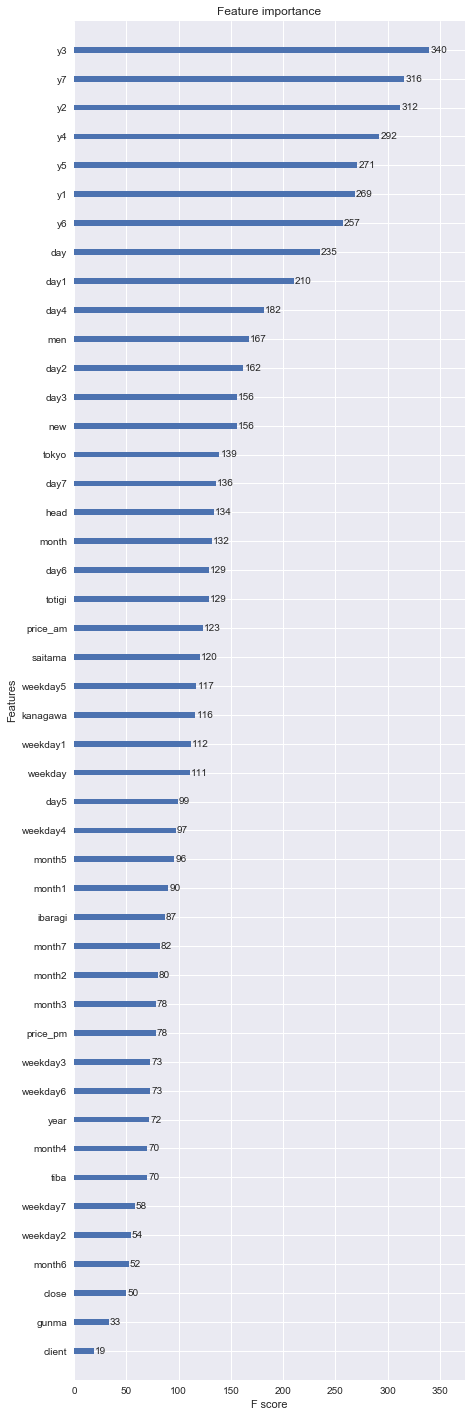

In [44]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

In [44]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predicts = []
for i in range(100):
    train_predict = models[i].predict(dfeature)
    train_predicts.append(train_predict)

In [60]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(365, 47)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,new,total,men,head,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa
0,1,0,3,2,2016,4,1,4,105.0,99.0,98.0,86.0,94.0,93.0,90.0,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,3,25,4,63,23383,131,47,1532,1064,1031,3842,3324,7774,4816
1,0,0,5,5,2016,4,2,5,NaN,105.0,99.0,98.0,86.0,94.0,93.0,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,63,23383,131,47,1532,1064,1031,3842,3324,7774,4816
2,1,0,2,2,2016,4,3,6,NaN,NaN,105.0,99.0,98.0,86.0,94.0,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,63,23383,131,47,1532,1064,1031,3842,3324,7774,4816
3,1,0,1,1,2016,4,4,0,NaN,NaN,NaN,105.0,99.0,98.0,86.0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,63,23383,131,47,1532,1064,1031,3842,3324,7774,4816
4,0,0,1,1,2016,4,5,1,NaN,NaN,NaN,NaN,105.0,99.0,98.0,4,4,0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,63,23383,131,47,1532,1064,1031,3842,3324,7774,4816


In [46]:
def y_predict(feature):
    dtest = xgb.DMatrix(feature.values.reshape((1,-1)), feature_names=feature_name)
    test_predicts =[]
    for i in range(100):
        test_predict = models[i].predict(dtest)
        test_predicts.append(test_predict)
    test_predict = sum(test_predicts)/100
    return(test_predict)

In [62]:
def y_copy(i):
        test_feature.loc[i+1,"y7"] = test_feature.loc[i,"y6"]
        test_feature.loc[i+1,"y6"] = test_feature.loc[i,"y5"]
        test_feature.loc[i+1,"y5"] = test_feature.loc[i,"y4"]
        test_feature.loc[i+1,"y4"] = test_feature.loc[i,"y3"]
        test_feature.loc[i+1,"y3"] = test_feature.loc[i,"y2"]
        test_feature.loc[i+1,"y2"] = test_feature.loc[i,"y1"]
        test_feature.loc[i+1,"y1"] = y_predict(test_feature.loc[i,:])

In [63]:
for i in range(test_feature.shape[0]-1):
    y_copy(i)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
train_predicts =[]
for i in range(100):
    train_predict = models[i].predict(dfeature)
    train_predicts.append(train_predict)
train_predict = sum(train_predicts)/100

In [81]:
test_predicts =[]
for i in range(100):
    dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
    test_predict = models[i].predict(dtest)
    test_predicts.append(test_predict)
test_predict = sum(test_predicts)/100

In [82]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(2094, 2)


,predict,datetime
0,11.536304,2010-07-08
1,13.443707,2010-07-09
2,18.233658,2010-07-10
3,15.027316,2010-07-11
4,12.333351,2010-07-12


In [83]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(365, 2)


,predict,datetime
0,72.598938,2016-04-01
1,66.915276,2016-04-02
2,70.338280,2016-04-03
3,69.543816,2016-04-04
4,66.116676,2016-04-05


In [84]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2459, 2)


,predict,datetime
0,11.536304,2010-07-08
1,13.443707,2010-07-09
2,18.233658,2010-07-10
3,15.027316,2010-07-11
4,12.333351,2010-07-12


In [85]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

In [86]:
te_predict= te_predict.ix[:,['datetime','predict']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [87]:
te_predict.loc[test.loc[:,"close"] ==1,"predict"] =0#おまじない

In [88]:
te_predict.to_csv("submission.csv",header=None,index=None)